# Problema del taxista

Como se ha explicado en el trabajo teórico, el objetivo del problema del taxista es que el agente sea capaz de recoger a un cliente en una de entre 4 casillas predefinidas y lo lleve a otra de dichas 4 casillas. Lo resolveremos tanto usando el algoritmo Sarsa como mediante $Q$-*learning*.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import math

from gym.wrappers import RecordVideo
from collections import defaultdict, deque
from time import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Definición del agente
Lo primero que haremos será definir la clase `Agent` que almacenará toda la información relevante sobre el agente.

In [2]:
class Agent:
    
    # eps      : Nivel de ecploración
    # gamma    : Tasa de descuento
    # alpha    : Constante de paso
    # nActions : Tamaño del espacio de acciones
    def __init__(self,eps=0.1,gamma=0.9,alpha=0.1,nActions=6):
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.nActions = nActions

        # Q_LEARNING : Es un diccionario que almacenará la aproximación de Q usando el algoritmo Q-Learning
        # Q_SARSA    : Es un diccionario que almacenará la aproximación de Q usando el algoritmo Sarsa
        # Ambos diccionario tienen la misma estructura, Q[state] devuelve un vector con el valor asociado
        # a cada una de las acciones
        self.Q_LEARNING = defaultdict(lambda: np.zeros(self.nActions))
        self.Q_SARSA = defaultdict(lambda: np.zeros(self.nActions))

    # La función e_greedy(state) recibe un estado y un modelo y devuelve la acción que deberá realizar
    # el agente siguiendo una política epsilón-voraz adociada al modelo correspondiente
    def e_greedy(self, model, state):
        if model == 0:
            Q = self.Q_SARSA
        elif model == 1:
            Q = self.Q_LEARNING

        if np.random.random() > self.eps:
            return np.argmax(Q[state])
        else:
            return np.random.choice(self.nActions)

    # La función episodeSarsa() ejecuta un episodio completo siguiendo el algoritmo Sarsa
    def episodeSarsa(self, seed):
        reward_total = 0
        state = env.reset(seed=seed)
        action = agent.e_greedy(0,state)

        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            reward_total += reward

            next_action = agent.e_greedy(0,next_state)

            target = reward + self.gamma*self.Q_SARSA[next_state][next_action]
            self.Q_SARSA[state][action] += self.alpha*(target - self.Q_SARSA[state][action])            

            state = next_state
            action = next_action

        return reward_total

    # La función episodeQLearning() ejecuta un episodio completo siguiendo el algoritmo Q-Learning
    def episodeQLearning(self, seed):
        reward_total = 0
        state = env.reset(seed=seed)

        done = False
        while not done:
            action = agent.e_greedy(1,state)
            next_state, reward, done, _ = env.step(action)
            reward_total += reward

            target = reward + self.gamma*np.max(self.Q_LEARNING[next_state])
            self.Q_LEARNING[state][action] += self.alpha*(target - self.Q_LEARNING[state][action])
    
            state = next_state
        
        return reward_total

## Definición del entramiento del agente

Una vez definido el comportamiento del agente simplemente debemos de entrenar al agente mientras no se cumpla la condición de parada. En este caso la condición de parada es un número máximo de episodios (`num_episodes`). Para poder comparar los resultados con los presentes en la [clasificación](https://github.com/openai/gym/wiki/Leaderboard#taxi-v3) de Gym calcularemos la recompensa media obtenida en los últimos 100 episodios en todos los episodios.

Como se ha explicado en la parte teórica, antes de cada episodio se generará una semilla aleatoria que se usará para inicializar el episodio para cada uno de los algoritmos, de esta forma se busca que la comparación entre los métodos sea lo más fiel posible.

In [3]:
def run(env=gym.make("Taxi-v3"),agent=Agent(),num_episodes=20000):
    # avg_rewards_QLEARNING : Será un vector en la que almacenaremos las medias de las últimas 100 recompensas
    #                         obtenidas usando Q-Learning
    # avg_rewards_SARSA     : Será un vector en la que almacenaremos las medias de las últimas 100 recompensas
    #                         obtenidas usando Sarsa
    avg_rewards_QLEARNING = np.zeros(num_episodes-99)
    avg_rewards_SARSA = np.zeros(num_episodes-99)

    # best_avg_reward_QLEARNING : Será el valor de la mejor recompensa obtenida usando Q-Learning, se irá 
    #                             actualizando durante el entrenamiento
    # best_avg_reward_SARSA     : Será el valor de la mejor recompensa obtenida usando Sarsa, se irá 
    #                             actualizando durante el entrenamiento
    best_avg_reward_QLEARNING = -math.inf
    best_avg_reward_SARSA = -math.inf

    # memory_QLEARNING : Almacenará las últimas 100 recompensas obtenidas mediante Q-Learning
    # memory_Sarsa     : Almacenará las últimas 100 recompensas obtenidas mediante Sarsa
    memory_QLEARNING = deque(maxlen=100)
    memory_SARSA = deque(maxlen=100)

    t0 = time()
    for nEpisode in range(1,num_episodes+1):
        # Generamos una semilla aleatoria para poder entrenar a ambos agentes con los mismos estados iniciales
        seed = np.random.randint(10**10)

        # Iremos reduciendo el nivel de exploración pues conforme más entrenemos mejores serán las aproximaciones
        # que poseamos y con ellas mejor será actuar de forma voraz
        agent.eps = agent.eps / nEpisode

        episode_QLearning = agent.episodeQLearning(seed)
        memory_QLEARNING.append(episode_QLearning)
        
        episode_Sarsa = agent.episodeSarsa(seed)
        memory_SARSA.append(episode_Sarsa)

        if nEpisode >= 100:
            avg_reward_QLEARNING = np.mean(memory_QLEARNING)
            avg_rewards_QLEARNING[nEpisode-100] = avg_reward_QLEARNING
            if avg_reward_QLEARNING > best_avg_reward_QLEARNING:
                best_avg_reward_QLEARNING = avg_reward_QLEARNING

            avg_reward_SARSA = np.mean(memory_SARSA)            
            avg_rewards_SARSA[nEpisode-100] = avg_reward_SARSA
            if avg_reward_SARSA > best_avg_reward_SARSA:
                best_avg_reward_SARSA = avg_reward_SARSA
        
        print("\rEpisodio %i/%i: Q_LEARNING: Mejor recompensa media %.4f <-> SARSA: Mejor recompensa media %.4f"%(nEpisode, num_episodes, best_avg_reward_QLEARNING,best_avg_reward_SARSA), end="", flush=True)

    print('\nEntrenamiento terminado en %.2fs'%(time()-t0))

    return avg_rewards_QLEARNING, avg_rewards_SARSA, best_avg_reward_QLEARNING, best_avg_reward_SARSA

In [4]:
env = gym.make('Taxi-v3')
# La siguiente línea permite grabar el entrenamiento de los agentes, en concreto grabará cada
# 500 iteraciones para cada uno de ellos
#env = RecordVideo(env,'./video_train/',lambda x: x % 1000 == 0 or x % 1000 == 1)
agent = Agent(eps=0.1,gamma=0.99, alpha = 0.1, nActions=env.action_space.n)
rewards_QL, rewards_S, best_QL, best_S = run(env,agent = agent,num_episodes=5000)

Episodio 5000/5000: Q_LEARNING: Mejor recompensa media 8.4500 <-> SARSA: Mejor recompensa media 8.450000000
Entrenamiento terminado en 7.55s


El entrenamiento normalmente dura unos 10 segundos y la mejor recompensa media para ambos métodos es mayor que 8.5.

## Representación de los datos obtenidos

In [5]:
def graph(rewards_QL,rewards_S,save=False):
    fig, ax = plt.subplots(1,1,figsize=(14,7))

    ax.plot(range(1,len(rewards_QL)+1), list(rewards_QL),'b')
    ax.plot(range(1,len(rewards_S)+1), list(rewards_S),'r')
    ax.plot([0,len(rewards_QL)+1],[0,0],'k-')

    ax.legend(["Q-Learning","Sarsa"],fontsize=15)
    ax.set_ylabel("Recompensa media 100 episodios",fontsize=20)
    ax.set_xlabel("Número episodio",fontsize=20);

    # Zoom a la zona en la que se obtiene recompensa positiva
    axins = inset_axes(ax, width=7, height=3, loc=7)
    axins.plot(range(1,len(rewards_QL)+1), list(rewards_QL),'b')
    axins.plot(range(1,len(rewards_S)+1), list(rewards_S),'r')
    axins.plot([0,len(rewards_QL)+1],[0,0],'k-')
    x1 = 1000
    x2 = len(rewards_QL)+1
    y1 = -5
    y2 = 10
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    if save:
        plt.savefig("ComparacionQL_Sarsa.png",format="png",dpi=300)

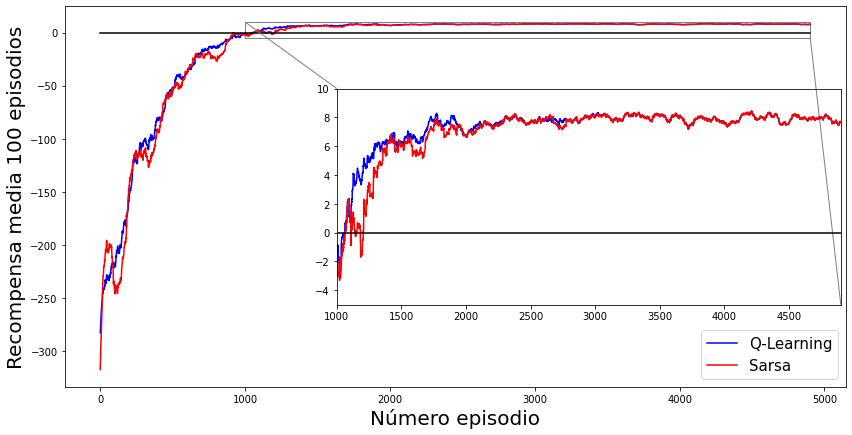

In [6]:
graph(rewards_QL,rewards_S)